## Predicting the weather using ridge regression

In [3]:
import pandas as pd
from IPython.display import display
# read the weather data and make the DATE col the index col
weather = pd.read_csv("weather_data.csv", index_col="DATE")

In [4]:
weather

,STATION,NAME,ACMH,ACSH,AWND,DAPR,FMTM,FRGT,MDPR,PGTM,...,WT01,WT02,WT03,WT04,WT05,WT07,WT08,WT09,WT16,WT18
DATE,,,,,,,,,,,,,,,,,,,,,
1960-01-01,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-02,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
1960-01-03,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-04,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-05,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-27,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,4.70,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-28,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,4.92,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-29,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,4.25,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We're going to look at how many missing values we have per column.

In [5]:
weather.apply(pd.isnull).sum() / weather.shape[0]

STATION    0.000000
NAME       0.000000
ACMH       0.658964
ACSH       0.658964
AWND       0.513947
DAPR       0.999533
FMTM       0.872199
FRGT       0.999883
MDPR       0.999533
PGTM       0.503268
PRCP       0.016398
SNOW       0.335901
SNWD       0.328665
TAVG       0.881127
TMAX       0.000642
TMIN       0.000817
TSUN       0.932831
WDF1       0.658964
WDF2       0.513889
WDF5       0.519024
WDFG       0.750992
WSF1       0.658964
WSF2       0.513831
WSF5       0.519024
WSFG       0.750992
WT01       0.780462
WT02       0.980275
WT03       0.992997
WT04       0.999767
WT05       0.998366
WT07       0.999883
WT08       0.812442
WT09       0.999883
WT16       0.885913
WT18       0.999825
dtype: float64

Below we're going to copy the core date columns per the documentation and assign them to weather_core

In [6]:
weather_core = weather[["PRCP", "SNOW", "SNWD", "TMAX", "TMIN"]].copy()

In [7]:
weather_core.columns = ["precip", "snow", "snow_depth", "temp_max", "temp_min"]
weather_core.head()

,precip,snow,snow_depth,temp_max,temp_min
DATE,,,,,
1960-01-01,0.0,0.0,0.0,49.0,30.0
1960-01-02,0.0,0.0,0.0,49.0,29.0
1960-01-03,0.0,0.0,0.0,54.0,35.0
1960-01-04,0.0,0.0,0.0,54.0,36.0
1960-01-05,0.0,0.0,0.0,55.0,33.0


In [8]:
weather_core.apply(pd.isnull).sum() / weather_core.shape[0]

precip        0.016398
snow          0.335901
snow_depth    0.328665
temp_max      0.000642
temp_min      0.000817
dtype: float64

We can see that in the `precip` column about 1.6% percent of the values are null, for `snow` it's about 33.6%, for `snow_depth` it's about 32.9%, and for `temp_max` and `temp_min` it's below 1%.

In [9]:
weather_core["snow"].value_counts()

0.0    11379
1.0        1
Name: snow, dtype: int64

Looking at the `snow` column we can see that in Oakland it only snowed once since 1960 and there was only an inch of snow that day. So we can delete this column because our machine-learning algorithm won't be able to get any useful historical data.

In [10]:
del weather_core["snow"]

In [11]:
weather_core

,precip,snow_depth,temp_max,temp_min
DATE,,,,
1960-01-01,0.0,0.0,49.0,30.0
1960-01-02,0.0,0.0,49.0,29.0
1960-01-03,0.0,0.0,54.0,35.0
1960-01-04,0.0,0.0,54.0,36.0
1960-01-05,0.0,0.0,55.0,33.0
...,...,...,...,...
2022-10-27,0.0,NaN,69.0,43.0
2022-10-28,0.0,NaN,65.0,44.0
2022-10-29,0.0,NaN,68.0,42.0


In [12]:
weather_core["snow_depth"].value_counts()

0.0    11504
Name: snow_depth, dtype: int64

Because the `snow_depth` column is only filled with 0's (because it never snows in Oakland except for once) we can also delete this column as well.

In [13]:
del weather_core["snow_depth"]

In [14]:
weather_core[pd.isnull(weather_core["precip"])]

,precip,temp_max,temp_min
DATE,,,
1983-10-29,NaN,67.0,57.0
1983-10-30,NaN,70.0,63.0
1983-10-31,NaN,69.0,61.0
1983-11-12,NaN,63.0,55.0
1983-11-13,NaN,60.0,50.0
...,...,...,...
2013-12-15,NaN,58.0,33.0
2016-05-01,NaN,80.0,55.0
2016-05-02,NaN,68.0,53.0


In [15]:
weather_core.loc["1983-10-20":"1983-11-05",:]

,precip,temp_max,temp_min
DATE,,,
1983-10-20,0.00,73.0,52.0
1983-10-21,0.00,70.0,50.0
1983-10-22,0.00,70.0,50.0
1983-10-23,0.00,69.0,60.0
1983-10-24,0.00,73.0,58.0
1983-10-25,0.00,75.0,53.0
1983-10-26,0.00,79.0,53.0
1983-10-27,0.00,82.0,56.0
1983-10-28,0.00,74.0,56.0


In [16]:
weather_core["precip"].value_counts()

0.00    13922
0.01      442
0.02      200
0.03      123
0.04      104
        ...  
1.29        1
1.73        1
1.05        1
1.38        1
1.02        1
Name: precip, Length: 176, dtype: int64

I'm going to make the decision to fill all the `Null` values in the `precip` column with 0's because as we can see in the cell above most of the days in Oakland the precipitation is 0 so I see it as a safe bet.

In [17]:
weather_core["precip"] = weather_core["precip"].fillna(0)

In [18]:
weather_core[pd.isnull(weather_core["temp_max"])]

,precip,temp_max,temp_min
DATE,,,
2004-11-20,0.0,NaN,NaN
2013-06-16,0.0,NaN,NaN
2019-04-18,0.0,NaN,50.0
2019-04-21,0.0,NaN,52.0
2019-04-22,0.0,NaN,50.0
2020-08-29,0.0,NaN,NaN
2020-09-08,0.0,NaN,NaN
2020-09-09,0.0,NaN,NaN
2021-10-31,0.0,NaN,56.0


In [19]:
weather_core[pd.isnull(weather_core["temp_min"])]

,precip,temp_max,temp_min
DATE,,,
2004-11-20,0.0,NaN,NaN
2011-12-21,0.0,61.0,NaN
2011-12-22,0.0,62.0,NaN
2011-12-23,0.0,56.0,NaN
2011-12-24,0.0,55.0,NaN
2011-12-25,0.0,54.0,NaN
2013-06-16,0.0,NaN,NaN
2020-08-29,0.0,NaN,NaN
2020-09-08,0.0,NaN,NaN


As we can see that number of `Null` values for the `temp_max` and `temp_min` are few so we're going to use a forward fill to fill these Null values.

In [20]:
weather_core = weather_core.fillna(method="ffill")

In [21]:
weather_core.apply(pd.isnull).sum()

precip      0
temp_max    0
temp_min    0
dtype: int64

We need to check and see if all of our data types are numerical so we can use them for the machine learning algorithm.

In [22]:
weather_core.dtypes

precip      float64
temp_max    float64
temp_min    float64
dtype: object

In [23]:
weather_core.index

Index(['1960-01-01', '1960-01-02', '1960-01-03', '1960-01-04', '1960-01-05',
       '1960-01-06', '1960-01-07', '1960-01-08', '1960-01-09', '1960-01-10',
       ...
       '2022-10-22', '2022-10-23', '2022-10-24', '2022-10-25', '2022-10-26',
       '2022-10-27', '2022-10-28', '2022-10-29', '2022-10-30', '2022-10-31'],
      dtype='object', name='DATE', length=17136)

In [24]:
weather_core.index = pd.to_datetime(weather_core.index)

In [25]:
weather_core.index

DatetimeIndex(['1960-01-01', '1960-01-02', '1960-01-03', '1960-01-04',
               '1960-01-05', '1960-01-06', '1960-01-07', '1960-01-08',
               '1960-01-09', '1960-01-10',
               ...
               '2022-10-22', '2022-10-23', '2022-10-24', '2022-10-25',
               '2022-10-26', '2022-10-27', '2022-10-28', '2022-10-29',
               '2022-10-30', '2022-10-31'],
              dtype='datetime64[ns]', name='DATE', length=17136, freq=None)

In [26]:
weather_core.apply(lambda x: (x==9999).sum())

precip      0
temp_max    0
temp_min    0
dtype: int64

<AxesSubplot:xlabel='DATE'>

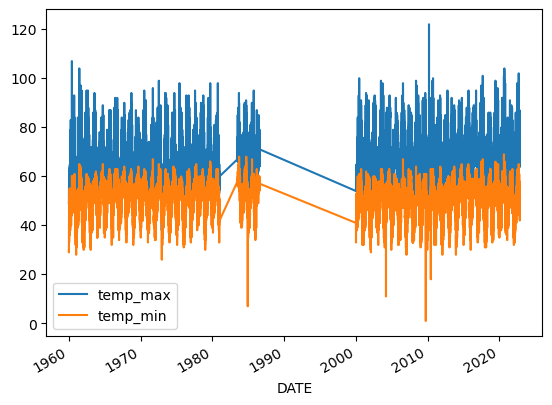

In [27]:
weather_core[["temp_max", "temp_min"]].plot()

In [28]:
weather_core.index.year.value_counts().sort_index()

1960    366
1961    365
1962    365
1963    365
1964    366
1965    365
1966    365
1967    365
1968    366
1969    365
1970    365
1971    365
1972    366
1973    365
1974    365
1975    365
1976    366
1977    365
1978    365
1979    365
1980    366
1983    184
1984    366
1985    365
1986    212
2000    365
2001    365
2002    365
2003    365
2004    366
2005    365
2006    365
2007    365
2008    366
2009    365
2010    365
2011    365
2012    365
2013    365
2014    365
2015    365
2016    366
2017    365
2018    365
2019    365
2020    366
2021    365
2022    304
Name: DATE, dtype: int64

We can see above that in 1983 data wasn't collected everyday since there are only 184 entries. We're also missing some years in the data set (1987 - 1999). But this missing data won't affect the machine learning algorithm so there is no urgent need to fill it, so we will leave it as is.

<AxesSubplot:xlabel='DATE'>

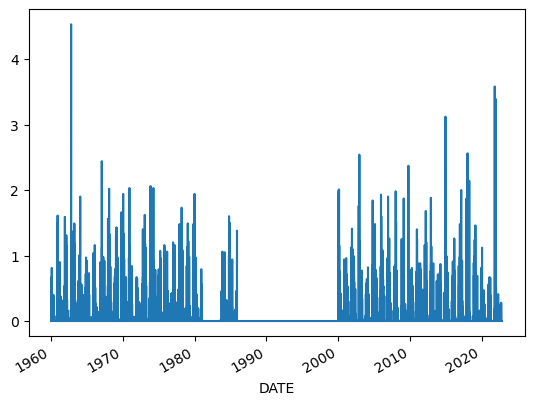

In [29]:
weather_core["precip"].plot()

In [30]:
weather_core.groupby(weather_core.index.year).sum()["precip"]

DATE
1960    14.01
1961    13.87
1962    22.47
1963    19.11
1964    16.83
1965    16.32
1966    13.11
1967    23.98
1968    17.19
1969    25.70
1970    25.31
1971    10.61
1972    16.27
1973    29.37
1974    16.87
1975    17.54
1976     8.64
1977    11.70
1978    22.57
1979    23.79
1980    13.58
1983     7.13
1984    16.03
1985     8.50
1986     0.00
2000    21.09
2001    22.84
2002    19.12
2003    11.37
2004    12.97
2005    27.37
2006    22.79
2007    12.79
2008    13.86
2009    14.57
2010    22.67
2011    16.06
2012    22.93
2013     4.89
2014    19.62
2015     8.58
2016    19.77
2017    23.34
2018    16.82
2019    20.00
2020     6.42
2021    20.82
2022     2.42
Name: precip, dtype: float64

We want our machine learning model to predict the maximum temperature for the next day, so we're going to create a new column `target` which holds the `max_temp` for the next day.

In [31]:
weather_core["target"] = weather_core.shift(-1)["temp_max"]

In [32]:
weather_core

,precip,temp_max,temp_min,target
DATE,,,,
1960-01-01,0.0,49.0,30.0,49.0
1960-01-02,0.0,49.0,29.0,54.0
1960-01-03,0.0,54.0,35.0,54.0
1960-01-04,0.0,54.0,36.0,55.0
1960-01-05,0.0,55.0,33.0,53.0
...,...,...,...,...
2022-10-27,0.0,69.0,43.0,65.0
2022-10-28,0.0,65.0,44.0,68.0
2022-10-29,0.0,68.0,42.0,65.0


We're going to remove the last row of `weather_core` because the `target` column has a NaN value in it.

In [33]:
weather_core = weather_core.iloc[:-1,:].copy()

In [34]:
weather_core

,precip,temp_max,temp_min,target
DATE,,,,
1960-01-01,0.0,49.0,30.0,49.0
1960-01-02,0.0,49.0,29.0,54.0
1960-01-03,0.0,54.0,35.0,54.0
1960-01-04,0.0,54.0,36.0,55.0
1960-01-05,0.0,55.0,33.0,53.0
...,...,...,...,...
2022-10-26,0.0,66.0,45.0,69.0
2022-10-27,0.0,69.0,43.0,65.0
2022-10-28,0.0,65.0,44.0,68.0


We're going to use `Ridge` regression to minimize overfitting.

In [35]:
from sklearn.linear_model import Ridge

reg = Ridge(alpha=.1)

In [36]:
predictors = ["precip", "temp_max", "temp_min"]

We're going to create a test set and a training set for the model. The training set will contain all the data up until December 31, 2020 and the test set will contain the data from January 1st, 2021 to October 30, 2022.

In [37]:
train = weather_core.loc[:"2020-12-31"]
test = weather_core.loc["2021-01-01":]

In [38]:
reg.fit(train[predictors], train["target"])

Ridge(alpha=0.1)

In [42]:
predictions = reg.predict(test[predictors])

In [43]:
from sklearn.metrics import mean_absolute_error

In [44]:
mean_absolute_error(test["target"], predictions)

3.4568730067444458

For our first attempt it seems like our predicted values were about 3.46 points off the actual temperature.

In [47]:
combined = pd.concat([test["target"], pd.Series(predictions, index=test.index)], axis=1)
combined.columns = ["actual", "predictions"]

In [48]:
combined

,actual,predictions
DATE,,
2021-01-01,57.0,59.806024
2021-01-02,56.0,59.310181
2021-01-03,62.0,58.538685
2021-01-04,59.0,61.531814
2021-01-05,59.0,59.444266
...,...,...
2022-10-26,69.0,65.031306
2022-10-27,65.0,66.835340
2022-10-28,68.0,64.130477


<AxesSubplot:xlabel='DATE'>

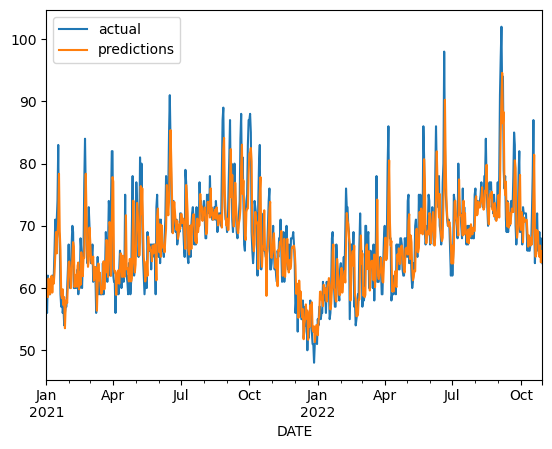

In [49]:
combined.plot()

Looking at the plot we can see that our predictions are a little more conservative than the actual values.

In [50]:
reg.coef_

array([-2.20730384,  0.72113834,  0.17969047])

In [60]:
# Create a function to iterate our model
def create_predictions(predictors, weather_core, reg):
    train = weather_core.loc[:"2020-12-31"]
    test = weather_core.loc["2021-01-01":]
    reg.fit(train[predictors], train["target"])
    predictions = reg.predict(test[predictors])
    error = mean_absolute_error(test["target"], predictions)
    combined = pd.concat([test["target"], pd.Series(predictions, index=test.index)], axis=1)
    combined.columns = ["actual", "predictions"]
    return error, combined

In [57]:
# Find the rolling mean for 30 days and assign that value to a new col "month_max"
weather_core["month_max"] = weather_core["temp_max"].rolling(30).mean()

In [53]:
weather_core

,precip,temp_max,temp_min,target,month_max
DATE,,,,,
1960-01-01,0.0,49.0,30.0,49.0,NaN
1960-01-02,0.0,49.0,29.0,54.0,NaN
1960-01-03,0.0,54.0,35.0,54.0,NaN
1960-01-04,0.0,54.0,36.0,55.0,NaN
1960-01-05,0.0,55.0,33.0,53.0,NaN
...,...,...,...,...,...
2022-10-26,0.0,66.0,45.0,69.0,70.800000
2022-10-27,0.0,69.0,43.0,65.0,70.800000
2022-10-28,0.0,65.0,44.0,68.0,70.633333


In [58]:
# Find the ratio between the maximum monthly temp and the temp on any given day
weather_core["month_day_max"] = weather_core["month_max"] / weather_core["temp_max"]

In [59]:
# Find the ratio between the maximum temp and the minimum temp
weather_core["max_min"] = weather_core["temp_max"] / weather_core["temp_min"]

In [56]:
predictors = ["precip", "temp_max", "temp_min", "month_max", "month_day_max", "max_min"]

In [62]:
# Remove the first 30 rows of weather_core since the "month_max" col has NaN values in it
weather_core = weather_core.iloc[30:,:].copy()

In [64]:
error, combined = create_predictions(predictors, weather_core, reg)

In [65]:
error

3.3909929029330064

We can see that we reduced our error down from 3.46 to 3.39.

<AxesSubplot:xlabel='DATE'>

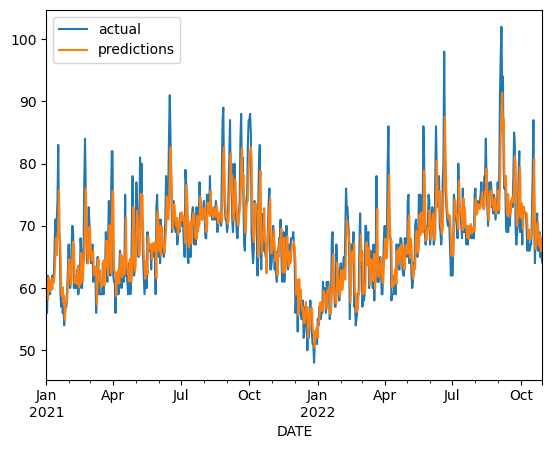

In [66]:
combined.plot()

In [67]:
# Group the max temps by month and use previous data to calculate the mean for that month
weather_core["monthly_avg"] = weather_core["temp_max"].groupby(weather_core.index.month).apply(lambda x: x.expanding(1).mean())

In [68]:
weather_core

,precip,temp_max,temp_min,target,month_max,month_day_max,max_min,monthly_avg
DATE,,,,,,,,
1960-03-01,0.00,55.0,43.0,58.0,59.866667,1.088485,1.279070,55.000000
1960-03-02,0.00,58.0,40.0,62.0,59.733333,1.029885,1.450000,56.500000
1960-03-03,0.00,62.0,47.0,62.0,59.833333,0.965054,1.319149,58.333333
1960-03-04,0.00,62.0,52.0,58.0,59.933333,0.966667,1.192308,59.250000
1960-03-05,0.13,58.0,54.0,59.0,59.866667,1.032184,1.074074,59.000000
...,...,...,...,...,...,...,...,...
2022-10-26,0.00,66.0,45.0,69.0,70.800000,1.072727,1.466667,70.556474
2022-10-27,0.00,69.0,43.0,65.0,70.800000,1.026087,1.604651,70.555403
2022-10-28,0.00,65.0,44.0,68.0,70.633333,1.086667,1.477273,70.551582


In [69]:
# Group the max_temps by the day of the year and find the mean using historical data 
weather_core["day_of_year_avg"] = weather_core["temp_max"].groupby(weather_core.index.day_of_year).apply(lambda x: x.expanding(1).mean())

In [70]:
weather_core

,precip,temp_max,temp_min,target,month_max,month_day_max,max_min,monthly_avg,day_of_year_avg
DATE,,,,,,,,,
1960-03-01,0.00,55.0,43.0,58.0,59.866667,1.088485,1.279070,55.000000,55.000000
1960-03-02,0.00,58.0,40.0,62.0,59.733333,1.029885,1.450000,56.500000,58.000000
1960-03-03,0.00,62.0,47.0,62.0,59.833333,0.965054,1.319149,58.333333,62.000000
1960-03-04,0.00,62.0,52.0,58.0,59.933333,0.966667,1.192308,59.250000,62.000000
1960-03-05,0.13,58.0,54.0,59.0,59.866667,1.032184,1.074074,59.000000,58.000000
...,...,...,...,...,...,...,...,...,...
2022-10-26,0.00,66.0,45.0,69.0,70.800000,1.072727,1.466667,70.556474,68.978723
2022-10-27,0.00,69.0,43.0,65.0,70.800000,1.026087,1.604651,70.555403,68.212766
2022-10-28,0.00,65.0,44.0,68.0,70.633333,1.086667,1.477273,70.551582,69.404255


In [71]:
predictors = ["precip", "temp_max", "temp_min", "month_max", "month_day_max", "max_min", "monthly_avg", "day_of_year_avg"]

In [72]:
error, combined = create_predictions(predictors, weather_core, reg)

In [73]:
error

3.3550269612145533

After adding two new predictors `monthly_avg` and `day_of_year_avg` our error has gone down slightly to 3.35. Which means that our predictions are within 3.35 degrees of the actual temperature.

In [74]:
reg.coef_

array([ -0.90657491,   0.40057565,   0.03082803,   0.33761669,
       -16.03804065,   0.04917173,   0.14250199,   0.08102419])

In [75]:
weather_core.corr()["target"]

precip            -0.205622
temp_max           0.821371
temp_min           0.594740
target             1.000000
month_max          0.686534
month_day_max     -0.422166
max_min            0.045580
monthly_avg        0.689611
day_of_year_avg    0.711899
Name: target, dtype: float64

In [76]:
combined["diff"] = (combined["actual"] - combined["predictions"]).abs()

In [77]:
combined.sort_values("diff", ascending=False).head()

,actual,predictions,diff
DATE,,,
2022-06-20,98.0,76.771169,21.228831
2022-05-23,86.0,69.836435,16.163565
2021-01-17,83.0,68.589700,14.410300
2022-09-03,91.0,76.694894,14.305106
2022-09-05,102.0,87.761557,14.238443
